# Отчет по модулю С

## Импорт библиотек

In [1]:
import pandas as pd

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, LabelEncoder, FunctionTransformer
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split

from sklearn.linear_model import LogisticRegression, LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC

from sklearn.metrics import accuracy_score, recall_score, f1_score, r2_score

import joblib

import matplotlib.pyplot as plt
import seaborn as sns

import datetime

## Импорт данных

In [2]:
data = pd.read_csv('../data/data.csv')
data.head(3)

,line,trip,hour,num_val,output_escalator_count,output_doors_count,output_turnstile_count,input_turnstile_total_bandwidth,input_turnstile_count,input_doors_count,entry_id,year,month,day,cluster
0,КАЛИНИНСКАЯ,Авиамотор-я КалЛ - Авиамотор-я КалЛ,1.0,5.0,0.0,5.0,8.0,13.0,13.0,5.0,5.0,2023,1,1,1
1,КАЛИНИНСКАЯ,Авиамотор-я КалЛ - Авиамотор-я КалЛ,5.0,18.0,0.0,5.0,8.0,13.0,13.0,5.0,5.0,2023,1,1,1
2,КАЛИНИНСКАЯ,Авиамотор-я КалЛ - Авиамотор-я КалЛ,6.0,160.0,0.0,5.0,8.0,13.0,13.0,5.0,5.0,2023,1,1,1


# 3.1 Обучение модели

### Проверим исходные данные на сбалансированность. 

Выполним агрегацию по кластерам и отобразим в процентном соотношении.

In [3]:
data['cluster'].value_counts(normalize=True) * 100

cluster
1    52.990199
2    36.004749
0    11.005052
Name: proportion, dtype: float64

В целом, у нас достаточное количество данных по каждому кластеру, но имеется дисбаланс. 

Проведем Oversampling для кластера под номером 0 – увеличим количество данных путем дублирования строк.

In [4]:
data = pd.concat([data, data[data['cluster'] == 0], data[data['cluster'] == 0]])
data['cluster'].value_counts(normalize=True) * 100

cluster
1    43.430993
2    29.509645
0    27.059362
Name: proportion, dtype: float64

Теперь дисбаланс устранен – количество наблюдений для каждого кластера примерно равно.

## Предобработка данных
Для проведения классификации предобработаем данные: заполним пропуски, закодируем категориальные признаки, отмасштабируем данные.

In [5]:
num_features = data.describe().columns.tolist()
cat_features = [col for col in data.columns if col not in num_features]


X = data.drop(['cluster'], axis=1)
y = data['cluster']

encoder = LabelEncoder()
X[cat_features] = X[cat_features].apply(encoder.fit_transform)

preprocessor = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

X = pd.DataFrame(preprocessor.fit_transform(X), columns=preprocessor.get_feature_names_out())
X.head(3)

,line,trip,hour,num_val,output_escalator_count,output_doors_count,output_turnstile_count,input_turnstile_total_bandwidth,input_turnstile_count,input_doors_count,entry_id,year,month,day
0,-0.837294,-1.564993,-1.654950,-1.146699,-0.28502,1.116194,1.46345,1.885103,1.886639,0.982929,-0.126283,0.0,-1.521568,-1.639671
1,-0.837294,-1.564993,-1.070716,-1.113858,-0.28502,1.116194,1.46345,1.885103,1.886639,0.982929,-0.126283,0.0,-1.521568,-1.639671
2,-0.837294,-1.564993,-0.924658,-0.755137,-0.28502,1.116194,1.46345,1.885103,1.886639,0.982929,-0.126283,0.0,-1.521568,-1.639671


In [37]:
joblib.dump(encoder, '../encoder.pkl')
joblib.dump(preprocessor, '../preprocessor.pkl')

['../preprocessor.pkl']

Разделим данные на обучающую и тестовую выборки в пропорции 80/20.

In [20]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=111)

####

### Проведем классификацию на выборке, сформированной в предыдущем модуле.

Рассмотрим алгоритмы классификации:
- **LogisticRegression** - статистическая модель, используемая для прогнозирования вероятности возникновения некоторого события путём его сравнения с логистической кривой.
- **RandomForest** - строится на основе ансамбля деревьев решений. Основная идея заключается в том, чтобы создать множество деревьев решений и объединить их результаты для получения более точного прогноза.
- **DecisionTree** -  метод представления решающих правил в определенной иерархии, включающей в себя элементы двух типов — узлов (node) и листьев (leaf). Узлы включают в себя решающие правила и производят проверку примеров на соответствие выбранного атрибута обучающего множества.

Оценивать модели будем по 3 метрикам:
- **accuracy**
- **precision**
- **f1**

### LogisticRegression

In [23]:
lr = LogisticRegression()
lr.fit(X_train, y_train)
lr_pred = lr.predict(X_test)

#### Метрики

In [28]:
print(f'Acccuracy для данной модели: {accuracy_score(y_test, lr_pred):.2f}')
print(f'Recall для данной модели: {recall_score(y_test, lr_pred, average='micro'):.2f}')
print(f'F1 для данной модели: {f1_score(y_test, lr_pred, average='micro'):.2f}')

Acccuracy для данной модели: 1.00
Recall для данной модели: 1.00
F1 для данной модели: 1.00


### RandomForest

In [29]:
rf = RandomForestClassifier()
rf.fit(X_train, y_train)
rf_pred = rf.predict(X_test)

#### Метрики

In [30]:
print(f'Acccuracy для данной модели: {accuracy_score(y_test, rf_pred):.2f}')
print(f'Recall для данной модели: {recall_score(y_test, rf_pred, average='micro'):.2f}')
print(f'F1 для данной модели: {f1_score(y_test, rf_pred, average='micro'):.2f}')

Acccuracy для данной модели: 1.00
Recall для данной модели: 1.00
F1 для данной модели: 1.00


### DecisionTree

In [31]:
dt = DecisionTreeClassifier()
dt.fit(X_train, y_train)
dt_pred = dt.predict(X_test)

#### Метрики

In [32]:
print(f'Acccuracy для данной модели: {accuracy_score(y_test, dt_pred):.2f}')
print(f'Recall для данной модели: {recall_score(y_test, dt_pred, average='micro'):.2f}')
print(f'F1 для данной модели: {f1_score(y_test, dt_pred, average='micro'):.2f}')

Acccuracy для данной модели: 1.00
Recall для данной модели: 1.00
F1 для данной модели: 1.00


### Вывод

Все модели показали отличную точность на тестовой выборке. Отдадим предпочтение модели **LogisticRegression** за ее скорость.

Будем использовать эту модель для дальнейшей работы.

In [36]:
joblib.dump(lr, '../lr.pkl')

['../lr.pkl']

#

# 3.2 Организация непрерывного обучения

Демонстрация непрерывного обучения представлена в каталоге ```stream_training```

#

# 3.3 Прогнозирование динамики изменения характеристик

Переформируем набор данных для обучения алгоритмов регрессии.

In [6]:
X = data.drop(['num_val'], axis=1)[['year', 'month', 'day', 'cluster']]
y = data['num_val']

preprocessor = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

X = pd.DataFrame(preprocessor.fit_transform(X), columns=preprocessor.get_feature_names_out())

joblib.dump(preprocessor, '../preprocessor_reg.pkl')

X_train, X_test, y_train, y_test = train_test_split(X[['year', 'month', 'day', 'cluster']], y, test_size=0.2, random_state=111)

X_train.head(3)

,year,month,day,cluster
1980325,0.0,0.271089,0.552272,1.297679
1555626,0.0,1.167418,1.821291,-0.032595
1273168,0.0,-0.625239,-0.832113,1.297679


### Рассмотрим алгоримты регрессии:
- **LinearRegression**
- **Ridge**
- **Lasso**


Выберем модель, согласно метрике **R2**.

## LinearRegression

In [20]:
linear_reg = LinearRegression()
linear_reg.fit(X_train, y_train)
linear_reg_pred = linear_reg.predict(X_test)
joblib.dump(linear_reg, '../linear_reg.pkl')

['../linear_reg.pkl']

### Метрика

In [21]:
print(f'Метрика R2 для данной модели составяет: {r2_score(y_test, linear_reg_pred):.2f}')

Метрика R2 для данной модели составяет: 0.07


## Ridge

In [22]:
ridge = Ridge()
ridge.fit(X_train, y_train)
ridge_pred = ridge.predict(X_test)
joblib.dump(ridge, '../ridge.pkl')

['../ridge.pkl']

### Метрика

In [23]:
print(f'Метрика R2 для данной модели составяет: {r2_score(y_test, ridge_pred):.2f}')

Метрика R2 для данной модели составяет: 0.07


## Lasso

In [24]:
lasso = Lasso()
lasso.fit(X_train, y_train)
lasso_pred = lasso.predict(X_test)
joblib.dump(lasso, '../lasso.pkl')

['../lasso.pkl']

### Метрика

In [25]:
print(f'Метрика R2 для данной модели составяет: {r2_score(y_test, lasso_pred):.2f}')

Метрика R2 для данной модели составяет: 0.07


### Вывод
Для прогнозирования используем LinearRegression, так как при одинаковом качестве моделей, LinearRegression обучился быстрее всех.

## Прогноз на 2 года

In [55]:
date = datetime.datetime(2023, 9, 1, 0, 0)
# Создаем данные на 2 года
date_interval = [date + datetime.timedelta(days=i) for i in range(365 + 365)]
# Данные с учетом кластеров
data_for_prediction = [pd.DataFrame({'date': date_interval, 'cluster': cluster}) for cluster in range(3)]
data_for_prediction = pd.concat(data_for_prediction)
data_for_prediction['year'] = data_for_prediction['date'].dt.year
data_for_prediction['month'] = data_for_prediction['date'].dt.month
data_for_prediction['day'] = data_for_prediction['date'].dt.day

# Обрабатываем данные
data_for_prediction[['year', 'month', 'day']] = \
pd.DataFrame(preprocessor.fit_transform(data_for_prediction[['year', 'month', 'day']]), columns=preprocessor.get_feature_names_out())

data_for_prediction.head()

,date,cluster,year,month,day
0,2023-09-01,0,-1.69553,0.719168,-1.674039
1,2023-09-02,0,-1.69553,0.719168,-1.560296
2,2023-09-03,0,-1.69553,0.719168,-1.446554
3,2023-09-04,0,-1.69553,0.719168,-1.332811
4,2023-09-05,0,-1.69553,0.719168,-1.219069


In [56]:
data_for_prediction['prediction'] = linear_reg.predict(data_for_prediction[['year', 'month', 'day', 'cluster']])

### Визуализация прогнозирования

<Axes: xlabel='date', ylabel='prediction'>

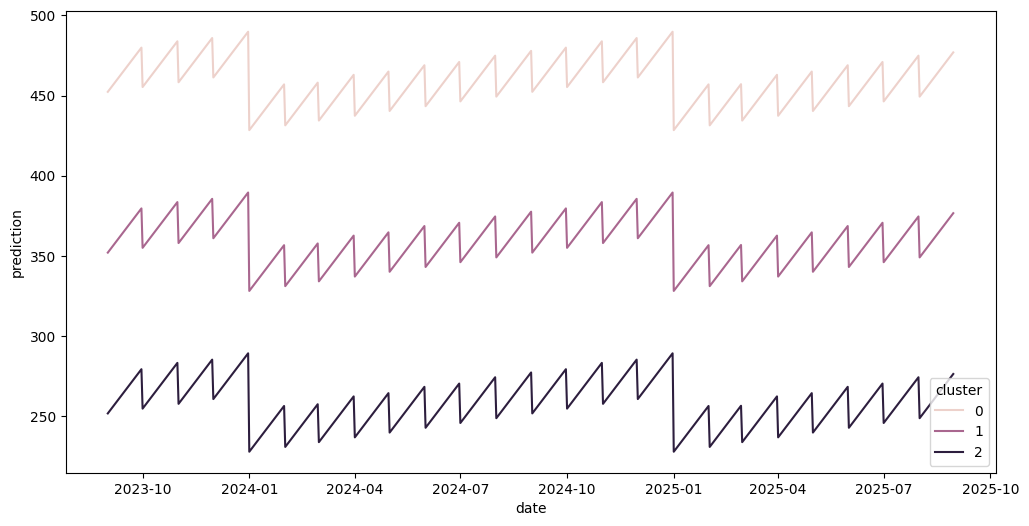

In [57]:
plt.figure(figsize=(12, 6))
sns.lineplot(data=data_for_prediction, x='date', y='prediction', hue='cluster')

#### Проверка качества модели проведена в сравнительном анализе 3 алгоритмов регрессиии.

# Отчет 
В ходе выполнения модуля С было сделано следующее:
- Выбрана и обучена модель классификации.
- Организовано непрерывное обучение модели.
- Выполнено прогнозирование загруженности станции на 2 года вперед.
- Подготовлен отчет.